Graph: 52 nodes, 345 edges, 2 components, initial LCC=50


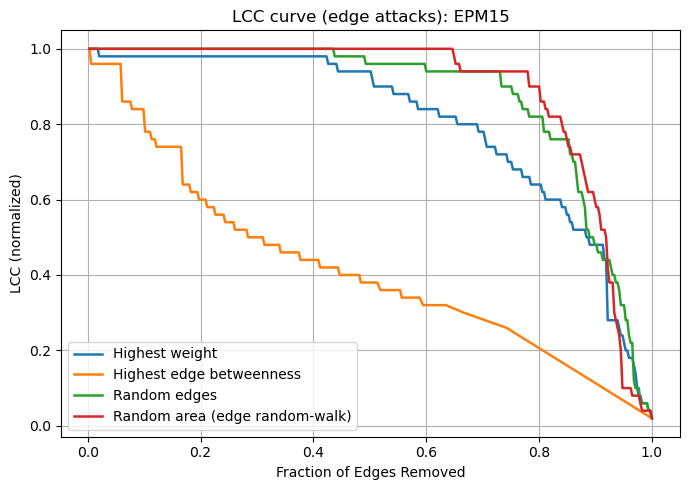

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

#EDGE_CSV_PATH = "C:/Users/ak4086/Desktop/Data TEMET/MTT/MTT04_ref_coref_edgelist.csv"#
#EDGE_CSV_PATH = "C:/Users/ak4086/Desktop/Data TEMET/PCR/PCR29_ref_coref_edgelist.csv"
EDGE_CSV_PATH = "C:/Users/ak4086/Desktop/Data TEMET/EPM/EPM15_ref_coref_edgelist.csv"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -----------------------
# Load + build graph
# -----------------------
df = pd.read_csv(EDGE_CSV_PATH).dropna(subset=["source", "target"])
df["weight"] = pd.to_numeric(df["weight"], errors="coerce").fillna(0.0)

G0 = nx.from_pandas_edgelist(
    df, source="source", target="target", edge_attr=True, create_using=nx.Graph()
)

def lcc_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(G), key=len))

initial_lcc = lcc_size(G0)
total_edges = G0.number_of_edges()

print(f"Graph: {G0.number_of_nodes()} nodes, {total_edges} edges, "
      f"{nx.number_connected_components(G0)} components, initial LCC={initial_lcc}")

# -----------------------
# Strategy 1: Highest weight first
# -----------------------
edges_sorted_by_weight = sorted(
    G0.edges(data=True),
    key=lambda x: x[2].get("weight", 0.0),
    reverse=True
)

Gw = G0.copy()
x_w, y_w = [], []
removed = 0

for u, v, d in edges_sorted_by_weight:
    if Gw.has_edge(u, v):
        Gw.remove_edge(u, v)
        removed += 1
        x_w.append(removed / total_edges)
        y_w.append(lcc_size(Gw) / initial_lcc)

# -----------------------
# Strategy 2: Highest edge betweenness first (recompute each step)
# -----------------------
Gb = G0.copy()
x_b, y_b = [], []
removed = 0

while Gb.number_of_edges() > 0:
    ebc = nx.edge_betweenness_centrality(Gb, normalized=True, weight=None)
    max_ebc = max(ebc.values())

    to_remove = [e for e, val in ebc.items()
                 if np.isclose(val, max_ebc, rtol=1e-12, atol=1e-15)]

    Gb.remove_edges_from(to_remove)
    removed += len(to_remove)

    x_b.append(removed / total_edges)
    y_b.append(lcc_size(Gb) / initial_lcc)

    if Gb.number_of_edges() == 0:
        break

# -----------------------
# Strategy 3: Random edge removal (uniform random)
# NOTE: better practice is to repeat many runs and average; this is 1 run.
# -----------------------
Gr = G0.copy()
x_r, y_r = [], []
removed = 0

while Gr.number_of_edges() > 0:
    e = random.choice(list(Gr.edges()))
    Gr.remove_edge(*e)
    removed += 1
    x_r.append(removed / total_edges)
    y_r.append(lcc_size(Gr) / initial_lcc)

# -----------------------
# Strategy 4: "Random area" / random-walk edge removal
# Pick a random edge, then keep removing a random adjacent edge (shares a node)
# If the last removed edge has no adjacent edges left, restart with a random edge.
# -----------------------
Graw = G0.copy()
x_rw, y_rw = [], []
removed = 0

last_edge = None

def adjacent_edges(G, edge):
    """Return edges in G that share an endpoint with 'edge', excluding the edge itself."""
    u, v = edge
    candidates = set(G.edges(u)) | set(G.edges(v))
    candidates.discard((u, v))
    candidates.discard((v, u))
    return list(candidates)

while Graw.number_of_edges() > 0:
    if last_edge is None:
        # start somewhere
        e = random.choice(list(Graw.edges()))
    else:
        nbrs = adjacent_edges(Graw, last_edge)
        if nbrs:
            e = random.choice(nbrs)
        else:
            # restart in a new area
            e = random.choice(list(Graw.edges()))

    # remove the chosen edge
    if Graw.has_edge(*e):
        Graw.remove_edge(*e)
        last_edge = e
        removed += 1
        x_rw.append(removed / total_edges)
        y_rw.append(lcc_size(Graw) / initial_lcc)
    else:
        # edge might have disappeared due to earlier removals; reset
        last_edge = None

# -----------------------
# Plot all 4 strategies
# -----------------------
plt.figure(figsize=(7, 5))

plt.plot(x_w,  y_w,  linewidth=1.8, label="Highest weight")
plt.plot(x_b,  y_b,  linewidth=1.8, label="Highest edge betweenness")
plt.plot(x_r,  y_r,  linewidth=1.8, label="Random edges")
plt.plot(x_rw, y_rw, linewidth=1.8, label="Random area (edge random-walk)")

plt.title("LCC curve (edge attacks): EPM15")
plt.xlabel("Fraction of Edges Removed")
plt.ylabel("LCC (normalized)")
plt.grid(True)
plt.legend(ncol=1)
plt.tight_layout()
plt.show()